In [1]:
%pip install opendatasets --upgrade --quiet

import opendatasets as od
import os
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


C:\Users\igors\AppData\Local\Temp\ipykernel_25484\1415932937.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# insert ypu kaggle  username and key
od.download('https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small',data_dir="dataset")

Skipping, found downloaded files in "dataset\fashion-product-images-small" (use force=True to force download)


In [3]:
df = pd.read_csv('dataset/fashion-product-images-small/styles.csv', on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
sample_df = df.sample(n=2000, random_state=0)
sample_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
1665,49093,Women,Personal Care,Lips,Lip Liner,Mauve,Spring,2017.0,Casual,Deborah 24 Ore Lip Liner 220
411,59600,Women,Apparel,Saree,Sarees,Rust,Fall,2012.0,Ethnic,FNF Rust Wedding Collection Sari
23153,6815,Men,Footwear,Shoes,Casual Shoes,Brown,Fall,2012.0,Casual,Timberland Men's Chocorua Trail Brown Shoe
10894,54869,Women,Accessories,Jewellery,Necklace and Chains,Gold,Fall,2012.0,Casual,Ivory Tag Women Colour Interplay Multicolour N...
20533,37638,Men,Accessories,Accessories,Accessory Gift Set,Tan,Summer,2012.0,Casual,Wills Lifestyle Men Leather Accessory Gift Set


In [5]:
%pip install sweetviz
import sweetviz as sv

Note: you may need to restart the kernel to use updated packages.


c:\Users\igors\anaconda3\envs\techlabs_dl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sample_report = sv.analyze(sample_df, pairwise_analysis="on")

Feature: id                                  |▉         | [  9%]   00:00 -> (00:00 left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


In [7]:
sample_report.show_html(layout='vertical')

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### My personal data and model Exploration

In [8]:
# use either small or large dataset
SMALL_DATASET = True

In [9]:
# insert ypu kaggle  username and key
if (SMALL_DATASET):
    od.download('https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small',data_dir="dataset")

Skipping, found downloaded files in "dataset\fashion-product-images-small" (use force=True to force download)


In [10]:
if (SMALL_DATASET):
    df_data = pd.read_csv("dataset/fashion-product-images-small/styles.csv", on_bad_lines='skip')
    image_files = os.listdir("dataset/fashion-product-images-small/images")
else:
    df_data = pd.read_csv("../input/fashion-product-images-dataset/fashion-dataset/styles.csv", on_bad_lines='skip')
    image_files = os.listdir("../input/fashion-product-images-dataset/fashion-dataset/images")

### Clean Data from nulls and non existing images

In [11]:
df_data.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [12]:
df_data.dropna(inplace=True)

In [13]:
#check if file exists
df_data['file_found'] = df_data['id'].apply(lambda x: f"{x}.jpg" in image_files)

In [14]:
df_data['file_found'].value_counts()

file_found
True     44072
False        5
Name: count, dtype: int64

In [15]:
mask = df_data['file_found']
df_data = df_data[mask].reset_index(drop=True)

### Add paths to images and review dataset

In [16]:
# insert ypu kaggle  username and key
if (SMALL_DATASET):
    df_data['filename'] = df_data['id'].apply(lambda x: os.path.join("dataset/fashion-product-images-small/images/",str(x)+".jpg"))
else:
    df_data['filename'] = df_data['id'].apply(lambda x: os.path.join("../input/fashion-product-images-dataset/fashion-dataset/images/",str(x)+".jpg"))

In [17]:
df_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,file_found,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,True,dataset/fashion-product-images-small/images/15...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,True,dataset/fashion-product-images-small/images/39...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,True,dataset/fashion-product-images-small/images/59...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,True,dataset/fashion-product-images-small/images/21...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,True,dataset/fashion-product-images-small/images/53...


In [18]:
#Reduce size of the dataset for test purposes
df_data = df_data.head(2000)

### Convert images to the numpy 3d matrix in order to later use them in the NN.
##### 3d matrix represents width, height and 3 colours

In [19]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [20]:
image_path = df_data['filename'][500]
image = load_img(image_path)
image = img_to_array(image)
image.shape

(80, 60, 3)

In [21]:
#normalize images by fixing width and height
if (SMALL_DATASET):
    IMAGE_WIDTH = 60
    IMAGE_HEIGHT = 60
else:
    IMAGE_WIDTH = 250
    IMAGE_HEIGHT = 250

In [22]:
def process_image(image_path):
    image = load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT,3))
    image = img_to_array(image)
    return image

In [23]:
def append_images(column):
    images = []
    for file_path in column:
        images.append(process_image(file_path))
    return np.array(images)

### Split Dataset and Encode Labels

In [24]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [25]:
output_labels = ["gender","masterCategory","subCategory","articleType","baseColour","season","usage"]

In [26]:
(X_filepath_train, X_filepath_test, 
 y_train,y_test) = train_test_split(df_data["filename"],df_data[output_labels],
                                                    test_size=0.2, random_state=42)

In [27]:
X_train = append_images(X_filepath_train)
X_test = append_images(X_filepath_test)

In [28]:
y_train.head()

,gender,masterCategory,subCategory,articleType,baseColour,season,usage
968,Women,Apparel,Apparel Set,Kurta Sets,Pink,Fall,Ethnic
240,Men,Footwear,Shoes,Casual Shoes,Brown,Summer,Casual
819,Women,Accessories,Wallets,Wallets,Red,Summer,Casual
692,Women,Accessories,Bags,Handbags,Pink,Summer,Casual
420,Women,Apparel,Topwear,Tshirts,Red,Summer,Casual


### Encode labels

In [29]:
label_encoders = {}
data_train = {}
data_test = {}

In [30]:
for label in output_labels:
    label_encoder = LabelBinarizer()
    encoded_data_train = label_encoder.fit_transform(y_train[label].to_numpy())
    encoded_data_test = label_encoder.transform(y_test[label].to_numpy())
    
    label_encoders[label] = label_encoder
    data_train[label] = encoded_data_train
    data_test[label] = encoded_data_test

### Create a modell

In [31]:
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense,BatchNormalization, MaxPooling2D, Conv2D, Activation, Input, Flatten,Dropout)

In [32]:
img_inputs = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = Conv2D(32, 3, padding='same', activation='relu')(img_inputs)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

In [33]:
def make_branch(res_input, n_out, name):
    x = Dense(256, activation='relu')(res_input)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(n_out)(x)
    x = Activation("softmax",name=name)(x)
    return x

In [34]:
branches = {}

In [35]:
for label in output_labels:
    branches[label] = make_branch(x, len(label_encoders[label].classes_),label)

In [36]:
model = Model(inputs=img_inputs,outputs=branches)

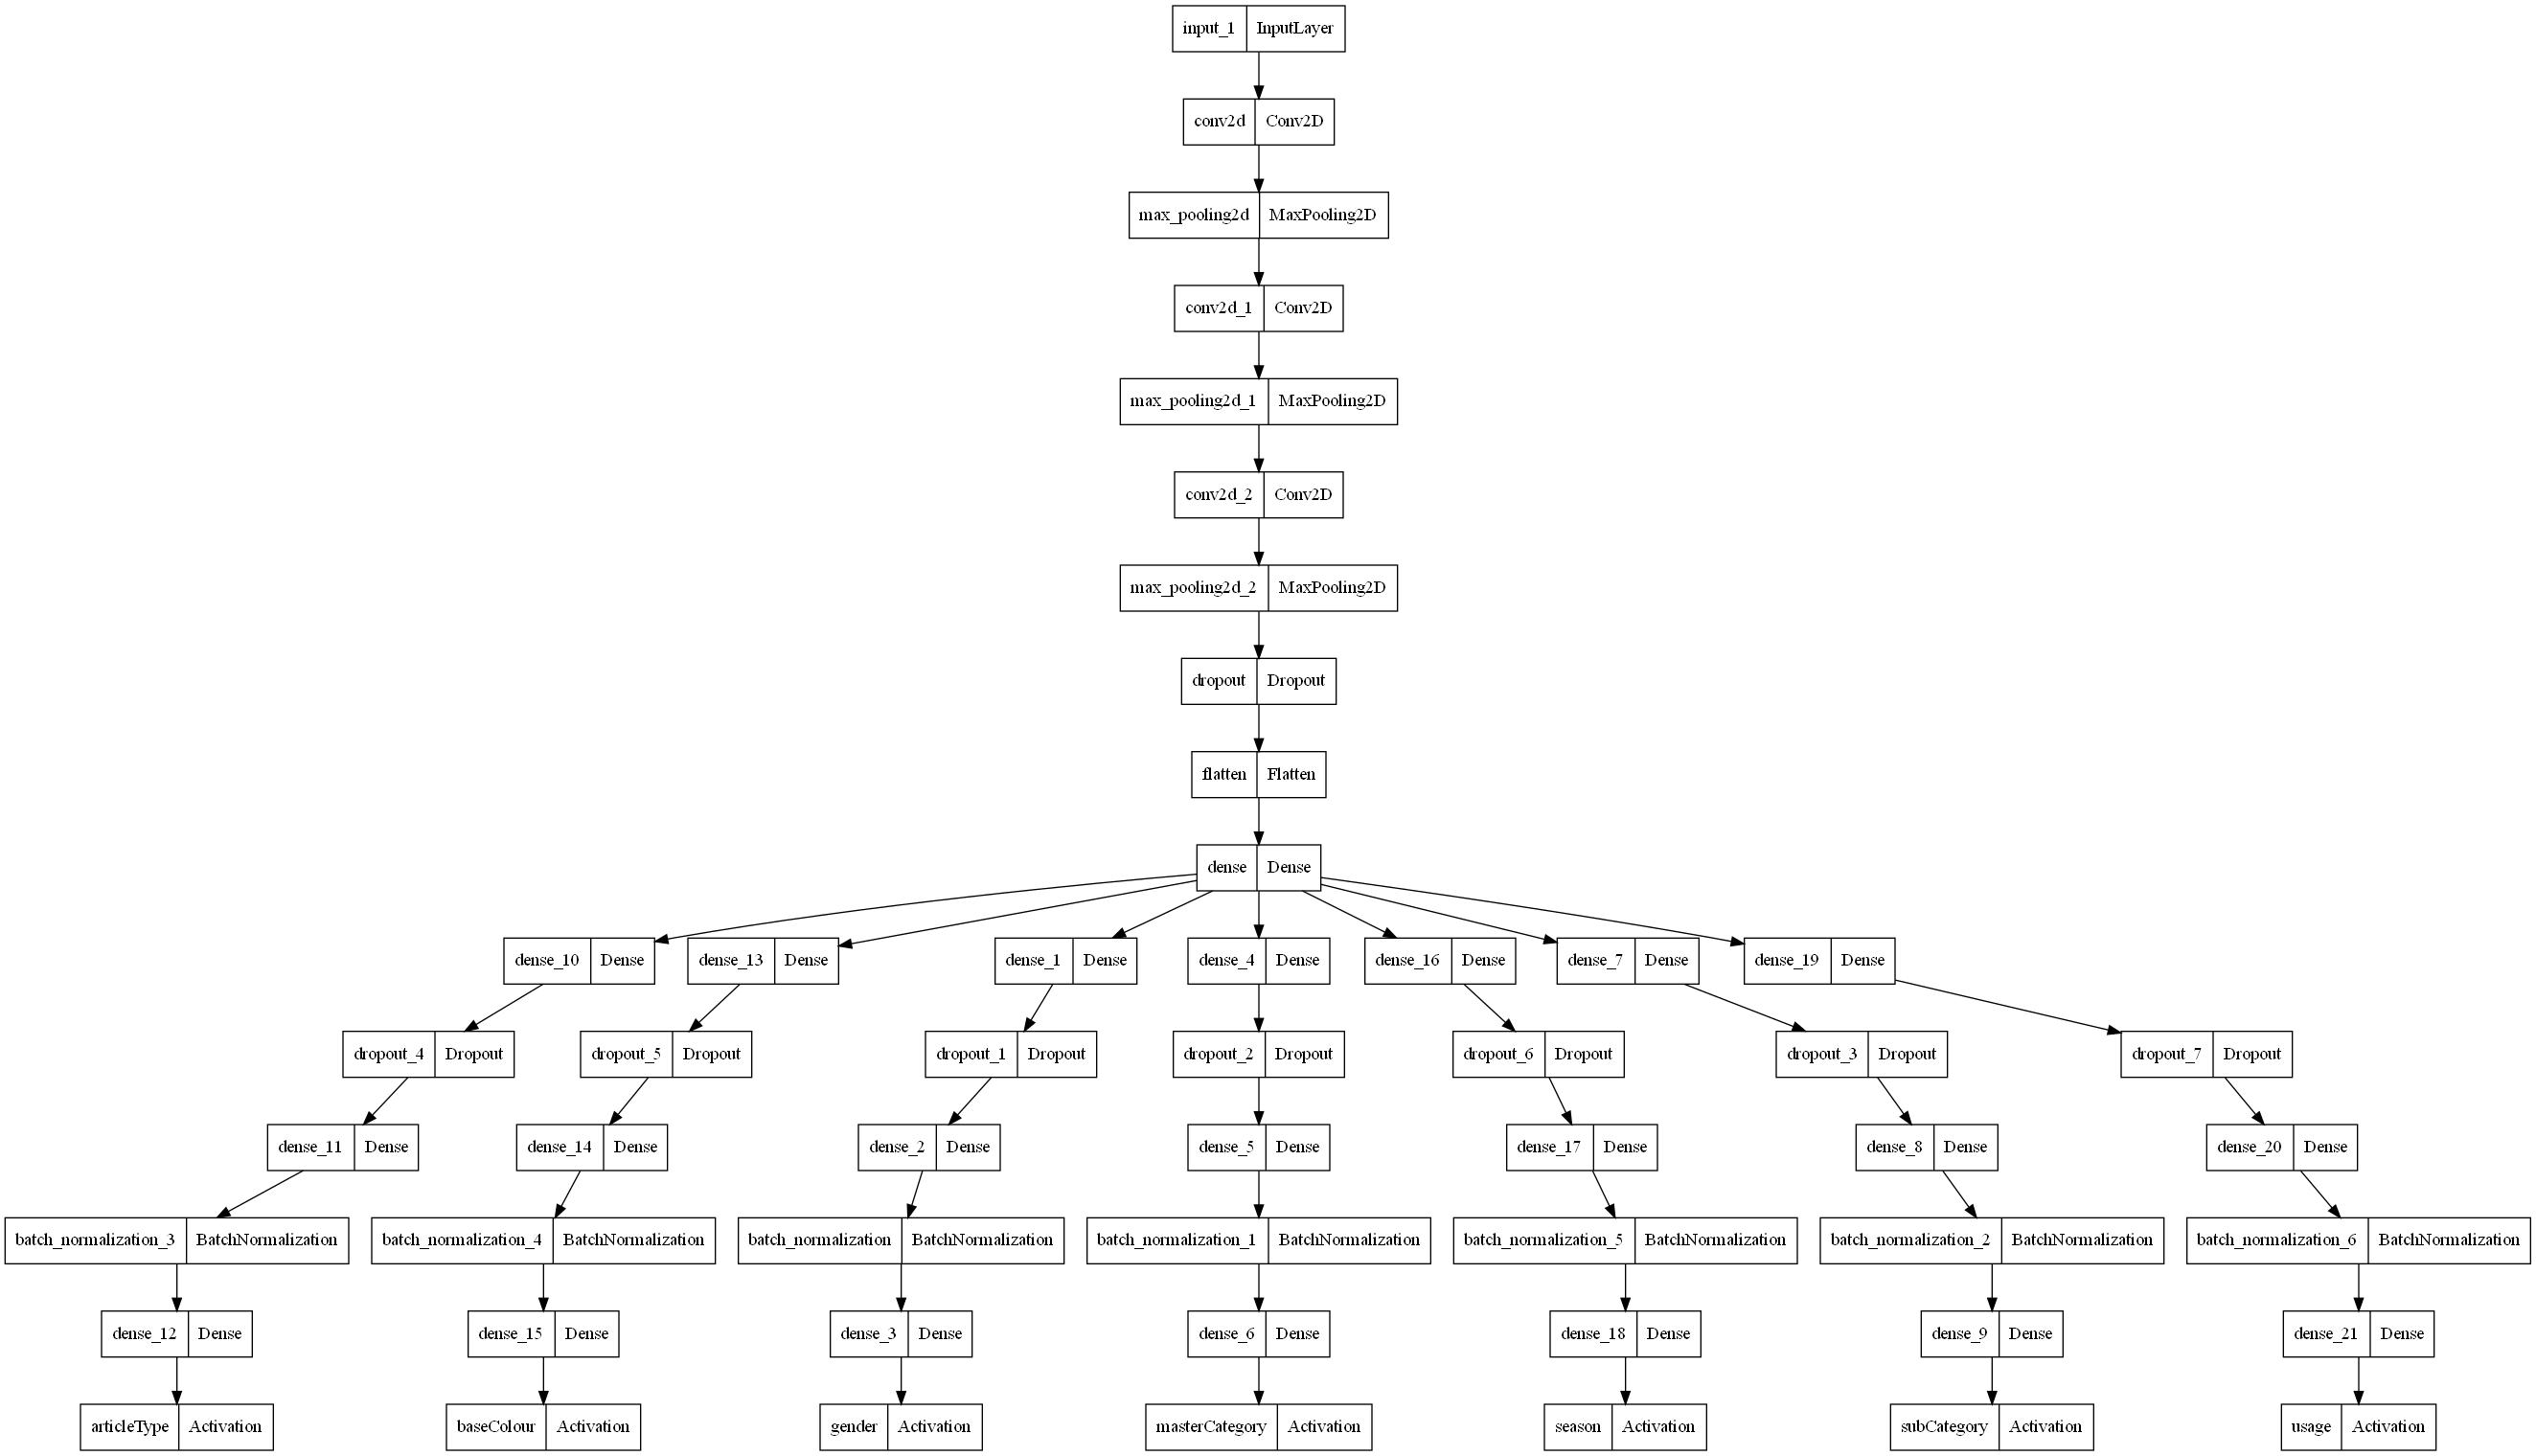

In [37]:
keras.utils.plot_model(model)

In [38]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")

### Train and evaluate model

In [39]:
EPOCHS=60
history = model.fit(
    X_train,
    data_train,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/60


50/50 [==============================] - 13s 94ms/step - loss: 19.4452 - articleType_loss: 4.7674 - baseColour_loss: 4.0519 - gender_loss: 1.7842 - masterCategory_loss: 1.7728 - season_loss: 1.5933 - subCategory_loss: 3.8184 - usage_loss: 1.6571 - articleType_accuracy: 0.0194 - baseColour_accuracy: 0.0538 - gender_accuracy: 0.2637 - masterCategory_accuracy: 0.2656 - season_accuracy: 0.3050 - subCategory_accuracy: 0.0600 - usage_accuracy: 0.3350
Epoch 2/60
50/50 [==============================] - 5s 93ms/step - loss: 16.8994 - articleType_loss: 4.5537 - baseColour_loss: 3.7555 - gender_loss: 1.3573 - masterCategory_loss: 1.4703 - season_loss: 1.3320 - subCategory_loss: 3.3367 - usage_loss: 1.0939 - articleType_accuracy: 0.0400 - baseColour_accuracy: 0.1019 - gender_accuracy: 0.4225 - masterCategory_accuracy: 0.3969 - season_accuracy: 0.4000 - subCategory_accuracy: 0.1462 - usage_accuracy: 0.7050
Epoch 3/60
50/50 [==============================] - 5s 92ms/step - loss: 14.697

<Axes: >

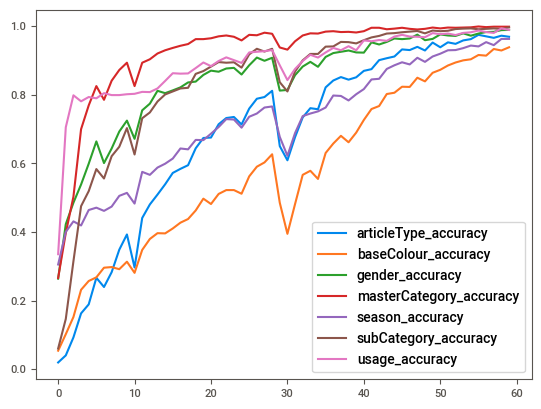

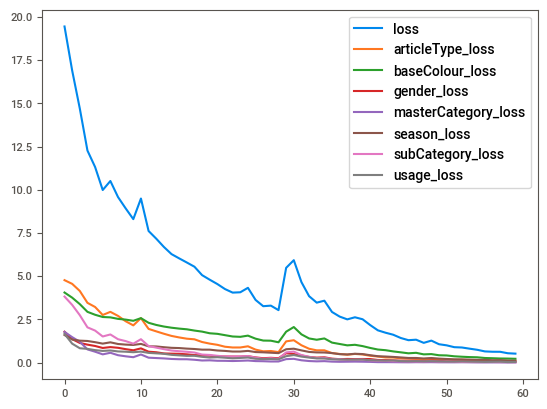

In [40]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,[col for col in history_df.columns if 'accuracy' in col and 'val' not in col]].plot()
history_df.loc[:,[col for col in history_df.columns if 'loss' in col and 'val' not in col]].plot()

### Save the model

In [42]:
model.save('models/basis_model.keras') 

### Evaluate model accuracy

In [43]:
outputs = model.predict(X_test)

13/13 [==============================] - 1s 19ms/step


In [68]:
predictions = {}
accuracies = {}

In [69]:
for label in output_labels:
    predictions[label] = label_encoders[label].classes_[outputs[label].argmax(axis=1)]

In [70]:
from sklearn.metrics import accuracy_score

In [71]:
for label in output_labels:
    accuracies[label] = accuracy_score(y_test[label],predictions[label])

In [80]:
for label in output_labels:
    print(
        "This model has accuracy of {:.2f}% for the label {}.".format(accuracies[label]*100,label)
    )

This model has accuracy of 81.25% for the lable gender.
This model has accuracy of 95.25% for the lable masterCategory.
This model has accuracy of 88.00% for the lable subCategory.
This model has accuracy of 69.00% for the lable articleType.
This model has accuracy of 46.50% for the lable baseColour.
This model has accuracy of 62.75% for the lable season.
This model has accuracy of 87.25% for the lable usage.


### show random image

In [74]:
import random
import matplotlib.pyplot as plt

In [75]:
image_path = X_filepath_test.sample().values[0]
input_image = np.expand_dims(process_image(image_path), axis=0)

In [76]:
output = model.predict(input_image)

1/1 [==============================] - 0s 138ms/step


In [77]:
for label in output_labels:    
    output[label] = output[label][0]

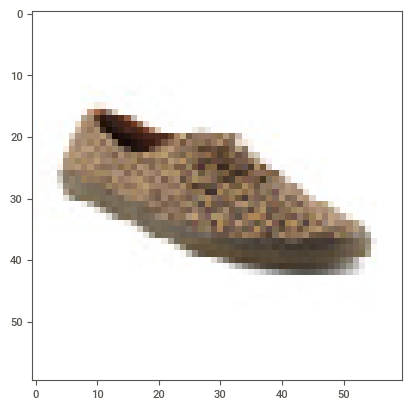

This items gender is most likely Men. With a 99.97 percent confidence.
This items masterCategory is most likely Footwear. With a 100.00 percent confidence.
This items subCategory is most likely Shoes. With a 99.97 percent confidence.
This items articleType is most likely Casual Shoes. With a 94.55 percent confidence.
This items baseColour is most likely Brown. With a 99.56 percent confidence.
This items season is most likely Summer. With a 63.65 percent confidence.
This items usage is most likely Casual. With a 100.00 percent confidence.


In [78]:
image = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
plt.imshow(image, interpolation='nearest')
plt.show()
for label in output_labels:
    print(
        "This items {} is most likely {}. With a {:.2f} percent confidence."
        .format(label,label_encoders[label].classes_[output[label].argmax()], 100 * output[lable].max())
    )